In [7]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeSherbrooke # For simulation with realistic noise

objective_func_vals = []
numOptimisations = 0 # Tracks iterations within a single minimize call
RESULTS_FOLDER = "depth_testing_results"

In [8]:
def generate_results_filename(problem_type, num_qubits, simulator_name):
    # Sanitize simulator_name for filename (e.g., remove specific instance details if any)
    sim_name_clean = simulator_name.split('(')[0].replace('-', '_').lower()
    return f"depth_results_{str(problem_type).replace(' ', '_')}_{num_qubits}q_{sim_name_clean}.json"

def load_results_data(filename, current_problem_type, current_num_qubits, current_simulator_name):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
                # Validate if the loaded data matches current experiment parameters
                if (data.get("problem_type") == current_problem_type and
                    data.get("num_qubits") == current_num_qubits and
                    data.get("simulator_name") == current_simulator_name):
                    print(f"Successfully loaded existing results from {filename}")
                    return data
                else:
                    print(f"Warning: File {filename} exists but metadata does not match current experiment. Starting fresh for this combination.")
                    # Fall through to return a new structure
            except json.JSONDecodeError:
                print(f"Warning: File {filename} is corrupted or not valid JSON. Starting fresh.")
                # Fall through to return a new structure
    # If file doesn't exist, or loading failed, or metadata mismatch, create a new structure
    print(f"No valid existing results file found or metadata mismatch for this configuration. Creating new data structure for {filename}.")
    return {
        "problem_type": current_problem_type,
        "num_qubits": current_num_qubits,
        "simulator_name": current_simulator_name,
        "results_by_depth": {} # Stores lists of costs: { "p_depth_str": [cost1, cost2, ...] }
    }

def save_results_data(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Results updated and saved to {filename}")

def load_qubo_and_build_hamiltonian(file_path="qubo_data.json"):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        qubo_data = json.load(f)

    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset, backend_total_qubits=127): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    objective_func_vals.append(cost_float)
    
    numOptimisations = numOptimisations + 1
    #print(f"Params: {params}, Cost: {cost_float}, Optimisation Round: {numOptimisations}") 
    print(f"Optimisation Iteration: {numOptimisations}", end="\r")  
    
    return cost_float

In [9]:
cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian("qubo_data.json")
print("Cost Function Hamiltonian (from QUBO):", cost_hamiltonian)
print("Constant offset:", constant_offset)
print(f"Number of qubits (inferred from terms): {num_qubits}")
print("Problem type:", problem_type)

Cost Function Hamiltonian (from QUBO): SparsePauliOp(['IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'IIIZZI', 'IIZIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII', 'ZIZIII', 'ZZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])
Constant offset: 0
Number of qubits (inferred from terms): 6
Problem type: maximum_cut


In [10]:
backend_simulator = AerSimulator.from_backend(FakeSherbrooke())
#backend_simulator = AerSimulator() # Ideal simulator for use getting the script to work
estimator = Estimator(mode=backend_simulator)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)

if "fake" in backend_simulator.name.lower():
    simulator_name_for_file = backend_simulator.name.split('(')[1].lower().replace(')', '') # e.g., "fakebrisbane"
else:
    simulator_name_for_file = "aer_simulator_ideal" # Or backend_simulator.name()

base_filename = generate_results_filename(problem_type, num_qubits, simulator_name_for_file)
results_filename_with_path = os.path.join(RESULTS_FOLDER, base_filename)
ALL_RESULTS_DATA = load_results_data(results_filename_with_path, problem_type, num_qubits, simulator_name_for_file)


Successfully loaded existing results from depth_testing_results/depth_results_maximum_cut_6q_fake_sherbrooke.json


In [19]:
#Iteration and Optimization
depth_list = [3,4]
repetitions_per_depth = 30
average_costs_by_depth = {}
average_costs_for_plotting = {}
current_repetition_num = 0

#trying to get it to save data in .json !!!!!!!!!! need to take out the AI guff!!!!!!!!!!!
for p_depth in depth_list:
    print(f"\n--- Processing Depth (p): {p_depth} for {problem_type} ({num_qubits}q) on {simulator_name_for_file} ---")
    
    depth_key = str(p_depth) # JSON keys must be strings

    # Initialize entry for this depth in ALL_RESULTS_DATA if it doesn't exist
    if depth_key not in ALL_RESULTS_DATA["results_by_depth"]:
        ALL_RESULTS_DATA["results_by_depth"][depth_key] = []

    # Retrieve existing results for this depth
    costs_at_this_depth_all_runs = ALL_RESULTS_DATA["results_by_depth"][depth_key]
    
    num_existing_runs = len(costs_at_this_depth_all_runs)
    num_runs_needed = repetitions_per_depth - num_existing_runs

    if num_runs_needed <= 0:
        print(f"  Sufficient data ({num_existing_runs} runs) already exists for depth {p_depth}. Using stored results.")
        # Ensure we only use up to `repetitions_per_depth` for average calculation
        current_costs_for_average = costs_at_this_depth_all_runs[:repetitions_per_depth]
    else:
        print(f"  Found {num_existing_runs} existing runs for depth {p_depth}. Need {num_runs_needed} more runs.")
        
        if num_qubits == 0:
            print(f"  Skipping optimization for depth {p_depth} as num_qubits is 0.")
            # current_costs_for_average will remain as is (potentially empty or with few results)
            # or you can fill with NaNs if you want to show this gap in averages explicitly
            current_costs_for_average = costs_at_this_depth_all_runs # Use what's there
        else:
            circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p_depth)
            # No measure_all() for EstimatorV2
            
            try:
                candidate_circuit = pm.run(circuit)
            except Exception as transpile_err:
                print(f"  Error transpiling circuit for depth {p_depth}: {transpile_err}. Skipping this depth.")
                current_costs_for_average = costs_at_this_depth_all_runs # Use what's there
                num_runs_needed = 0 # Don't attempt runs
            
            if num_runs_needed > 0: # Check again in case transpilation failed
                print(f"  Circuit for depth {p_depth} created. Num params: {2*p_depth}. Transpiled depth: {candidate_circuit.depth()}")

                newly_computed_costs_for_this_depth = []
                for rep_n in range(num_runs_needed):
                    current_repetition_num = num_existing_runs + rep_n 
                    print(f"  Running Repetition {current_repetition_num + 1}/{repetitions_per_depth} for depth {p_depth}")
                    
                    objective_func_vals = [] # Reset for each minimize call
                    numOptimisations = 0   # Reset for each minimize call

                    num_params = 2 * p_depth
                    initial_betas = (np.random.rand(p_depth) * np.pi).tolist()
                    initial_gammas = (np.random.rand(p_depth) * (np.pi / 2)).tolist()
                    initial_params = initial_betas + initial_gammas
                    
                    # print(f"    Initial params: {np.round(initial_params,2)}") # Optional detailed print


                    result = minimize(
                        cost_func_estimator,
                        np.array(initial_params),
                        args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
                        method="COBYLA",
                        tol=1e-3,
                        options={"maxiter": 1000} # Your existing options
                    )
                    # The detailed print is now inside cost_func_estimator via "Opt Iter"
                    print(f"  Completed Rep {current_repetition_num + 1}: Optimal Cost = {result.fun:.4f}") # Summary print after minimize
                    newly_computed_costs_for_this_depth.append(float(f"{result.fun:.4f}")) # Store with fixed precision

                # Append newly computed costs to the list for this depth and save
                ALL_RESULTS_DATA["results_by_depth"][depth_key].extend(newly_computed_costs_for_this_depth)
                save_results_data(ALL_RESULTS_DATA, results_filename_with_path)
            
            current_costs_for_average = ALL_RESULTS_DATA["results_by_depth"][depth_key][:repetitions_per_depth]

    # Calculate average for plotting from the (potentially augmented) list of costs for this depth
    valid_costs_for_average = [c for c in current_costs_for_average if isinstance(c, (int, float)) and not np.isnan(c)]
    if valid_costs_for_average:
        average_cost = np.mean(valid_costs_for_average)
        average_costs_for_plotting[p_depth] = average_cost
        print(f"--- Average cost for depth {p_depth} (using up to {repetitions_per_depth} runs from file/new): {average_cost:.4f} ---")
    else:
        average_costs_for_plotting[p_depth] = float('nan')
        print(f"--- Not enough valid data to compute average for depth {p_depth} ---")



--- Processing Depth (p): 3 for maximum_cut (6q) on fake_sherbrooke ---
  Found 20 existing runs for depth 3. Need 10 more runs.
  Circuit for depth 3 created. Num params: 6. Transpiled depth: 311
  Running Repetition 21/30 for depth 3
  Completed Rep 21: Optimal Cost = -0.7881
  Running Repetition 22/30 for depth 3
  Completed Rep 22: Optimal Cost = -1.9834
  Running Repetition 23/30 for depth 3
  Completed Rep 23: Optimal Cost = -0.9468
  Running Repetition 24/30 for depth 3
  Completed Rep 24: Optimal Cost = -1.6616
  Running Repetition 25/30 for depth 3
  Completed Rep 25: Optimal Cost = -1.7036
  Running Repetition 26/30 for depth 3
  Completed Rep 26: Optimal Cost = -0.9448
  Running Repetition 27/30 for depth 3
  Completed Rep 27: Optimal Cost = -1.5640
  Running Repetition 28/30 for depth 3
  Completed Rep 28: Optimal Cost = -2.0596
  Running Repetition 29/30 for depth 3
  Completed Rep 29: Optimal Cost = -1.5015
  Running Repetition 30/30 for depth 3
  Completed Rep 30: Optim

Average costs by depth (from all stored data): {1: -1.7267633333333336, 2: -1.8264733333333332, 3: -1.5661333333333334, 4: -1.53066, 5: -0.897405, 6: -1.0374750000000001, 7: -0.6871099999999999, 8: -0.50639, 9: -0.27928000000000003, 10: -0.39387999999999995, 11: -0.18905, 12: -0.08345999999999999}


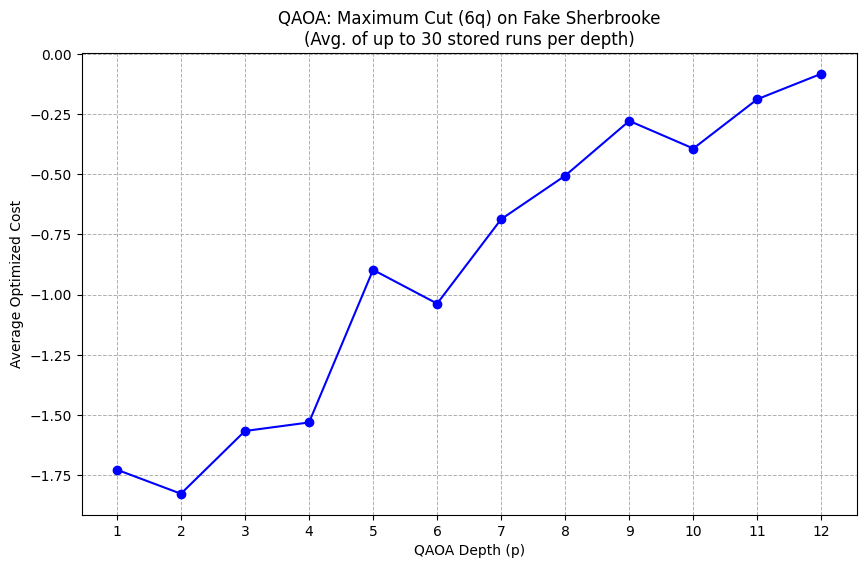

In [ ]:
#need to check for AI guff

stored_depth_keys_str = ALL_RESULTS_DATA["results_by_depth"].keys()
all_stored_depths_int = []
for k in stored_depth_keys_str:
    all_stored_depths_int.append(int(k))
all_stored_depths_int.sort() # Sort the depths numerically

# Calculate average costs for ALL depths found in the file
average_costs_from_file = {}
for p_depth_int in all_stored_depths_int:
    depth_key_str = str(p_depth_int)
    costs_for_this_depth = ALL_RESULTS_DATA["results_by_depth"].get(depth_key_str, [])
    
    # Ensure we only average up to 'repetitions_per_depth' if more are stored,
    # or all available if less than 'repetitions_per_depth' were successfully run and stored.
    # This aligns with how 'repetitions_per_depth' was used as a target.
    costs_to_average = costs_for_this_depth[:repetitions_per_depth]
    
    valid_costs = [c for c in costs_to_average if isinstance(c, (int, float)) and not np.isnan(c)]
    if valid_costs:
        average_costs_from_file[p_depth_int] = np.mean(valid_costs)
    else:
        average_costs_from_file[p_depth_int] = float('nan')

print("Average costs by depth (from all stored data):", average_costs_from_file)

# Prepare data for plotting
depths_to_plot = sorted([d for d in average_costs_from_file.keys() if not np.isnan(average_costs_from_file[d])])
avg_costs_to_plot = [average_costs_from_file[d] for d in depths_to_plot]

if depths_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(depths_to_plot, avg_costs_to_plot, marker='o', linestyle='-', color='b')
    plt.xlabel("QAOA Depth (p)")
    plt.ylabel("Average Optimized Cost")
    title_problem_type = str(ALL_RESULTS_DATA.get('problem_type', 'Unknown Problem')).replace('_', ' ').title()
    title_num_qubits = ALL_RESULTS_DATA.get('num_qubits', 'N/A')
    title_simulator = str(ALL_RESULTS_DATA.get('simulator_name', 'Unknown Simulator')).replace('_', ' ').title()
    
    # The 'repetitions_per_depth' variable should reflect the target number of runs
    # used when generating the data. If this varied, the title might need adjustment
    # or you could reflect the actual number of runs averaged for each point if it differs.
    # For now, assuming 'repetitions_per_depth' is the target/intended number.
    plt.title(f"QAOA: {title_problem_type} ({title_num_qubits}q) on {title_simulator}\n(Avg. of up to {repetitions_per_depth} stored runs per depth)")
    
    # Set x-ticks to show all integer depths present in the plotted data clearly
    if len(depths_to_plot) > 0:
        # Create a union of depth_list (if you want to ensure those ticks are present)
        # and all depths actually plotted.
        # For this request, we only plot what's in the file.
        x_ticks_to_show = sorted(list(set(map(int, depths_to_plot)))) # Ensure integer ticks
        if len(x_ticks_to_show) > 20: # Heuristic: if too many ticks, let matplotlib decide
             pass # Matplotlib will auto-select ticks
        elif len(x_ticks_to_show) > 0 :
             plt.xticks(x_ticks_to_show)
        # else, if depths_to_plot is empty or has few items, current xticks(depth_list) might be fine or auto
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.show()
else:
    print("No data available to plot from the stored results file.")
